In [2]:
# Citibike 2019 project, analyzing 2018 date of service trip data
# Author: George Chan, Sean Guo

# References Link from Google
# 01. https://stackoverflow.com/questions/522563/accessing-the-index-in-for-loops
# 02. https://stackoverflow.com/questions/39402795/how-to-pad-a-string-with-leading-zeros-in-python-3/39402910
# 03. https://stackoverflow.com/questions/17134716/convert-dataframe-column-type-from-string-to-datetime
# 04. https://stackoverflow.com/questions/24082784/pandas-dataframe-groupby-datetime-month
# 05. https://stackoverflow.com/questions/23402150/grouping-and-computing-frequency-pandas

In [3]:
# Import library and modules
import pandas as pd
import glob
import numpy as np
import os

In [4]:
# Define where are the citibke 2018 zipfiles
data_folder = r'/Users/Study/Citibike_Data/'
print('The data are stored in: ' + data_folder)

The data are stored in: /Users/Study/Citibike_Data/


In [32]:
# Check what are the files in that folder
for folderName, subfolders, filenames in os.walk(data_folder):
    print('Here are the list of csv zip files you have downloaded.\n')
    print(folderName)
        
    number_of_csv_file = 0
    all_files = []
    
    # Reference 01: How to get index within for loop?
    # Reference 02: How to pad number with leading zeros?
    for filename in filenames:
        if filename.endswith('.csv'):
            number_of_csv_file += 1
            print('\t' + str(number_of_csv_file).zfill(2) + ': ' + filename)
            all_files.append(data_folder + filename)
            
    # all_files = all_files.sort()
            
    # Warning message if you forgot to download all 12 months.
    # For our project we want exactly 12 file
    if number_of_csv_file != 12:
        print('Sorry, I think you are missing some files?')
        raise SystemExit

Here are the list of csv zip files you have downloaded.

/Users/Study/Citibike_Data/
	01: 201809-citibike-tripdata.csv
	02: 201801-citibike-tripdata.csv
	03: 201803-citibike-tripdata.csv
	04: 201805-citibike-tripdata.csv
	05: 201807-citibike-tripdata.csv
	06: 201811-citibike-tripdata.csv
	07: 201808-citibike-tripdata.csv
	08: 201802-citibike-tripdata.csv
	09: 201812-citibike-tripdata.csv
	10: 201804-citibike-tripdata.csv
	11: 201810-citibike-tripdata.csv
	12: 201806-citibike-tripdata.csv


In [33]:
# Creating a list of all CSV file in the path directory
# all_files = glob.glob(data_folder + "/*.csv")

# tempCitibike list that store the file data frame
tempCitibike = []

# Track how many records total
totalRecordCount = 0

# Loop and append the dataframes into tempCitibke List
for filename in sorted(all_files):
    # Filename is the path/file.ext
    print(os.path.basename(filename), end=" ")
    
    # df contains the entire dataset (CSV)
    df = pd.read_csv(filename) 
    
    # Radnomly select 10% of the data, with random_state = 1
    df = df.sample(frac = 0.10, replace = True, random_state = 1)
    
    # Output the (rowCount, columnCount) to terminal
    print("size: " + str(df.shape))
    
    totalRecordCount += df.shape[0]
    tempCitibike.append(df)

# Combine the tempCitibike dfs together
citibike = pd.concat(tempCitibike)
print("\nThere are " + "{:,}".format(totalRecordCount) + " number of records.")
print("Before dropping NaN: " + "{:,}".format(citibike.shape[0]))

# Drop rows with any (missing) variables
citibike.dropna(inplace = True)
print("After dropping NaN: " + "{:,}".format(citibike.shape[0]))

201801-citibike-tripdata.csv size: (71899, 15)
201802-citibike-tripdata.csv size: (84311, 15)
201803-citibike-tripdata.csv size: (97667, 15)
201804-citibike-tripdata.csv size: (130754, 15)
201805-citibike-tripdata.csv size: (182471, 15)
201806-citibike-tripdata.csv size: (195310, 15)
201807-citibike-tripdata.csv size: (191362, 15)
201808-citibike-tripdata.csv size: (197718, 15)
201809-citibike-tripdata.csv size: (187788, 15)
201810-citibike-tripdata.csv size: (187866, 15)
201811-citibike-tripdata.csv size: (126036, 15)
201812-citibike-tripdata.csv size: (101650, 15)

There are 1,754,832 number of records.
Before dropping NaN: 1,754,832
After dropping NaN: 1,754,557


In [7]:
# Sample my dataset
citibike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
128037,222,2018-09-03 11:44:21.4210,2018-09-03 11:48:04.4040,3260.0,Mercer St & Bleecker St,40.727064,-73.996621,3705.0,Thompson St & Bleecker St,40.728401,-73.999688,26630,Subscriber,1996,1
491755,599,2018-09-08 14:52:51.5460,2018-09-08 15:02:50.5470,297.0,E 15 St & 3 Ave,40.734232,-73.986923,368.0,Carmine St & 6 Ave,40.730386,-74.002150,34850,Subscriber,1968,1
470924,806,2018-09-08 10:56:45.0220,2018-09-08 11:10:11.2850,408.0,Market St & Cherry St,40.710762,-73.994004,408.0,Market St & Cherry St,40.710762,-73.994004,19890,Subscriber,1978,1
1840200,1457,2018-09-30 14:09:02.9470,2018-09-30 14:33:20.6020,312.0,Allen St & Stanton St,40.722055,-73.989111,2002.0,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,31979,Customer,1980,2
491263,1268,2018-09-08 14:47:38.4920,2018-09-08 15:08:46.9920,3528.0,Steinway St & 23 Ave,40.771394,-73.907744,3662.0,31 Ave & Steinway St,40.761294,-73.916917,34351,Customer,1992,2


# Question 01: What is monthly total ridership in 2018?

In [8]:
# What is the type of the starttime?
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'str'>
2018-09-03 11:44:21.4210


In [9]:
# Need to convert start_time and stop_time to datetime
from datetime import datetime

formatString = '%Y-%m-%d %H:%M:%S.%f'

# Reference 03: Convert datetime column into 
citibike['starttime'] = pd.to_datetime(citibike['starttime'], format=formatString)
citibike['stoptime'] = pd.to_datetime(citibike['stoptime'], format=formatString)

In [10]:
# Confirm such convertion work, should be datetime64!
print('Type: ' + str(type(citibike['starttime'].values[0])))
print(citibike['starttime'].values[0])

Type: <class 'numpy.datetime64'>
2018-09-03T11:44:21.421000000


In [11]:
# Reference 03: Group by month on datetime columns
# Create another pandas dataframe that only has 1 columns
citibike_monthly_df = citibike.filter(['starttime']) # Monthly dataframe
citibike_daily_df = citibike.filter(['starttime'])   # Daily dataframe

# Each of the starttime is now converted into YYYY-MM
citibike_monthly_df.starttime = pd.to_datetime(citibike_monthly_df.starttime).dt.to_period('m')
citibike_daily_df.starttime = pd.to_datetime(citibike_daily_df.starttime).dt.to_period('d')

# Confirm if they are correct
citibike_daily_df.head()
citibike_monthly_df.head()

,starttime
128037,2018-09
491755,2018-09
470924,2018-09
1840200,2018-09
491263,2018-09


In [12]:
# Get frequency count of ridership data by month and day
monthly_answer = citibike_monthly_df.groupby(['starttime']).size()
daily_answer = citibike_daily_df.groupby(['starttime']).size()

In [13]:
type(monthly_answer)

pandas.core.series.Series

In [14]:
monthly_answer.plot(
    figsize = (20,10), 
    kind = 'bar',
    title = '2018 Monthly Citibike Ridership Count',
    fontsize = 12)

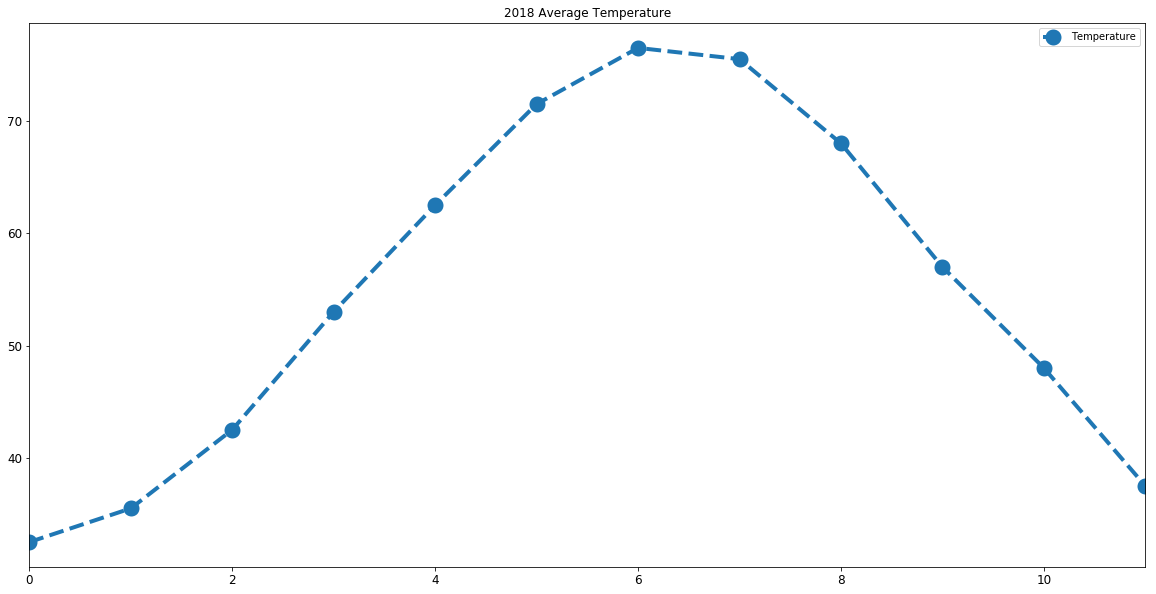

In [15]:
temperature_dict = {
    'Month':['2018-01', 
             '2018-02',
             '2018-03',
             '2018-04',
             '2018-05',
             '2018-06',
             '2018-07',
             '2018-08',
             '2018-09',
             '2018-10',
             '2018-11',
             '2018-12'],
    'Temperature':[32.5, 35.5, 42.5, 53, 62.5, 71.5, 76.5, 75.5, 68, 57, 48, 37.5]
}

temperature_df = pd.DataFrame.from_dict(temperature_dict)

temperature_df.plot(
    figsize = (20,10), 
    kind = 'line',
    title = '2018 Average Temperature',
    fontsize = 12,
    linewidth = 4.0, 
    markeredgewidth = 10.0,
    linestyle = '--', 
    marker = 'o')

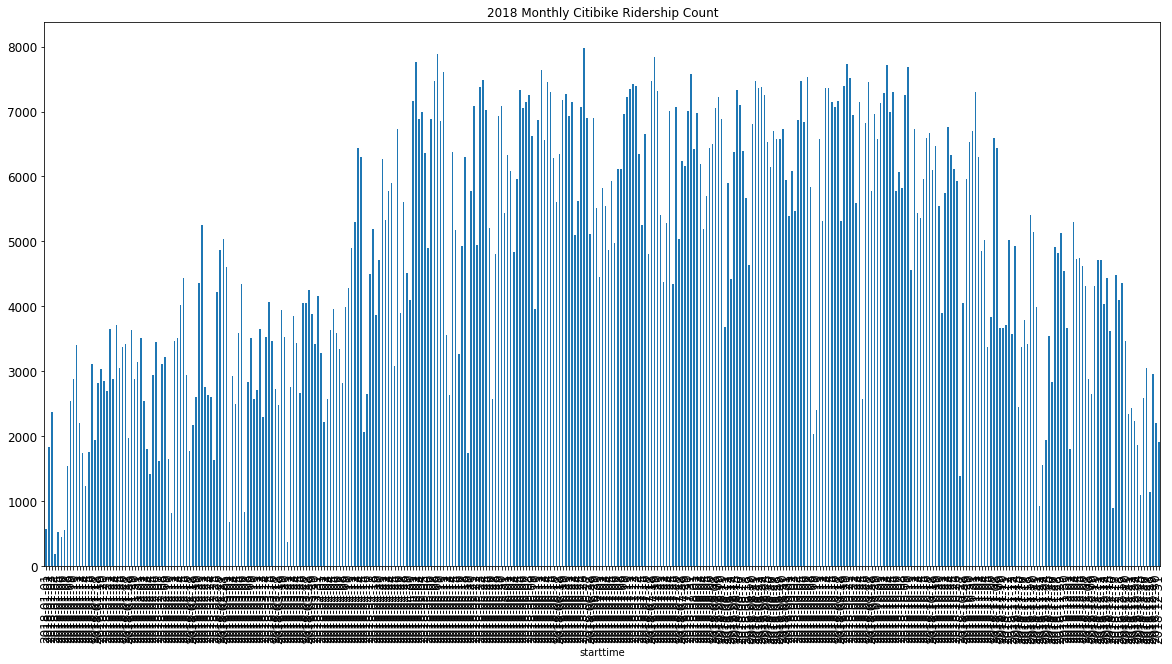

In [36]:
daily_answer.plot(
    figsize = (20,10), 
    kind = 'bar',
    title = '2018 Monthly Citibike Ridership Count',
    fontsize = 12)

# Question 02: Pending

In [17]:
# Enter Python & Pandas Code here :)

# Question 03: What is the most popular station?

In [18]:
# Most popular trip (Start|end station)
# Most busy start station
# Most busy end station
# Top 10 one way direction...

# School station analysis (Where do they go?)
# Male and Female trips
# Age Group

# Longest trip (Distance formula)
# Shortest trip (Distance formula)
# Holiday trip (Federal Holiday)

# Number of conected trip ...
# Start and end station by the same user?

# Analysis on commute habbit
# Year of Birth & Gender (Start time and station)
# Morning starting on the train station and ending on the same station